In [1]:
import os
from functools import wraps
from collections import defaultdict
from tqdm import tqdm

import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
import copy
import random
import time
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from argparse import ArgumentParser
from torchvision import transforms as tt
from PIL import Image
from utils import AverageMeter
from eval.finetune import *

In [2]:
# set manual seed for reproducibility
seed = 1234

In [3]:
# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# ('mnist', 'femnist', 'fmnist', 'cifar10', 'cifar100', 'svhn')
data_path = "./data"
dataset = "cifar10"
# ('noniid-labeldir', 'noniid-label#2', 'noniid-label#3','iid', 'default') default only for femnist
partition = "noniid-label#2"
client_num = 5
batch_size = 32
test_batch = 128
# ('linear', 'exp')
avg_freq = 10
# avg_freq = "linear"
sim_weight = True

In [6]:

# save_path = f"./model/SplitFSSL_resnet18/resnet18_cifar10_noniid_{batch_size}_{noniid_ratio}_{client_num}"
# save_path = f"./model/SplitFSSLMaxpool_resnet18/resnet18Maxpooling_cifar10_{batch_size}_{noniid_ratio}_{client_num}"
# save_path = f"./model/SplitFSSL_SimCLR/resnet18_simclr_{batch_size}_{noniid_ratio}_{client_num}"
# save_path = f"./model/SplitFSSL_SimSiam/resnet18_simsiam_{batch_size}_{noniid_ratio}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL_Avg25times/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL32_DifAvgtimes/resnet18Maxpooling_{dataset}_{batch_size}_{avg_freq}_{partition}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL_Cluster/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{noniid_ratio}_{client_num}"

In [7]:
save_path = f"./model/SplitFSSL_BYOL32_similarity/resnet18Maxpooling_sim_weight_softmax({sim_weight})_{dataset}_{batch_size}_{avg_freq}_{partition}_{client_num}"
print(save_path)

./model/SplitFSSL_BYOL32_similarity/resnet18Maxpooling_sim_weight_softmax(True)_cifar10_32_10_noniid-label#2_5


In [8]:

train_dataset = datasets.CIFAR10(
        "./data",
        download=True,
        transform=TransformsSimCLR(size=32).test_transform,
    )

test_dataset = datasets.CIFAR10(
    "./data",
    train=False,
    download=True,
    transform=TransformsSimCLR(size=32).test_transform,
)

label = train_dataset.targets
# non-IID
# traindict, finedict, _ = distribute_noniid_traindata_label(label, client_num)
# IID
traindict, finedict, _ = distribute_noniid_traindata_label(label, client_num, noniid_ratio = 1.0)

label = test_dataset.targets
_, _, classes_dict = distribute_noniid_traindata_label(label, client_num, noniid_ratio = 1.0)
# indices = torch.randperm(len(train_dataset))[:int(len(train_dataset)* data_portion)]
# train_dataset = torch.utils.data.Subset(train_dataset, indices)

# indices = torch.randperm(len(test_dataset))[:int(len(test_dataset)* data_portion)]
# test_dataset = torch.utils.data.Subset(test_dataset, indices)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        drop_last=False,
        num_workers=4,
    )
    
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    drop_last=False,
    num_workers=4,
)

In [10]:
epoch = 100
resnet = ResNet18(num_classes=10)
resnet.fc = MLP(resnet.feature_dim, 2048, 4096)
# resnet.load_state_dict(torch.load(save_path + "_final.pt", map_location=device))

# resnet.load_state_dict(torch.load(f"./model/SplitFSSL_resnet18/resnet18_cifar10_noniid_20_1.0_0904_final.pt", map_location=device))
# resnet.load_state_dict(torch.load(f"./model/FedAvg_resnet18/resnet18_cifar10_noniid_{batch_size}_{noniid_ratio}_{client_num}_final.pt", map_location=device))
if sim_weight:
    resnet.load_state_dict(torch.load(save_path + f"/epoch_{epoch}/client_0.pt", map_location=device))
    # resnet.load_state_dict(torch.load(save_path + f"/final/client_0.pt", map_location=device))
    print(save_path + f"/epoch_{epoch}/client_0.pt")
    # print(save_path + f"/final/client_0.pt")
else:
    resnet.load_state_dict(torch.load(save_path + f"_{epoch}_epoch.pt", map_location=device))
    # resnet.load_state_dict(torch.load(save_path + "_final.pt", map_location=device))
    print(save_path + f"_{epoch}_epoch.pt")
    # print(save_path + "_final.pt")
# print(save_path + "_final.pt")


resnet = resnet.to(device)

./model/SplitFSSL_BYOL32_similarity/resnet18Maxpooling_sim_weight_softmax(True)_cifar10_32_10_noniid-label#2_5/epoch_100/client_0.pt


In [11]:
num_features = list(resnet.children())[-1].in_features
num_features

512

In [12]:
# throw away fc layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
n_classes = 10 # CIFAR-10 has 10 classes

# fine-tune model
# logreg = Classifer(num_features, hidden_size=1024)
logreg = nn.Sequential(nn.Linear(num_features, n_classes))
logreg = logreg.to(device)
models = [copy.deepcopy(logreg).to(device) for idx in range(client_num)]
models_weights = [1/5 for i in range(client_num)]

In [13]:
logreg

Sequential(
  (0): Linear(in_features=512, out_features=10, bias=True)
)

In [14]:
epochs = 200
# loss / optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=logreg.parameters(), lr=0.001)
optimizer_models = [torch.optim.Adam(models[i].parameters(), lr =0.001) for i in range(len(models))]
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200)

In [15]:
print("Creating features from pre-trained model")
(train_X, train_y, test_X, test_y) = get_features(
    resnet, train_loader, test_loader, device
)

Creating features from pre-trained model
Step [0/391]	 Computing features...
Step [5/391]	 Computing features...
Step [10/391]	 Computing features...
Step [15/391]	 Computing features...
Step [20/391]	 Computing features...
Step [25/391]	 Computing features...
Step [30/391]	 Computing features...
Step [35/391]	 Computing features...
Step [40/391]	 Computing features...
Step [45/391]	 Computing features...
Step [50/391]	 Computing features...
Step [55/391]	 Computing features...
Step [60/391]	 Computing features...
Step [65/391]	 Computing features...
Step [70/391]	 Computing features...
Step [75/391]	 Computing features...
Step [80/391]	 Computing features...
Step [85/391]	 Computing features...
Step [90/391]	 Computing features...
Step [95/391]	 Computing features...
Step [100/391]	 Computing features...
Step [105/391]	 Computing features...
Step [110/391]	 Computing features...
Step [115/391]	 Computing features...
Step [120/391]	 Computing features...
Step [125/391]	 Computing featu

In [16]:
# test_y_dict, classes_dict = noniid_testdata_label(test_y, client_num, noniid_ratio, num_class=10)
# train_y_dict, _ = noniid_testdata_label(train_y, client_num, noniid_ratio, num_class=10)

# Fine tuning by all data(50000)

In [17]:
train_loader, test_loader, class_loader = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, None, classes_dict, 2048
)

In [18]:
# Train fine-tuned model
logreg.train()

p_bar = tqdm(range(epochs))
for epoch in range(epochs):
    # metrics = defaultdict(list)
    acctol = []
    losses = []
    for step, (h, y) in enumerate(test_loader):
        h = h.to(device)
        y = y.to(device)

        outputs = logreg(h)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acctol.append(accuracy)
        losses.append(loss.item())
        # metrics["Loss/train"].append(loss.item())
        # metrics["Accuracy/train"].append(accuracy)
    acctol = np.array(acctol)
    losses = np.array(losses)
    p_bar.set_description("Train Epoch: {epoch}/{epochs:4}.Loss: {loss:.4f}.Accuracy: {acc:.4f}.".format(
            epoch=epoch,
            epochs=epochs,
            loss=losses.mean(),
            acc=acctol.mean()))
    p_bar.update()
    # print(f"Epoch [{epoch}/{epochs}]: " + "\t".join([f"{k}: {np.array(v).mean()}" for k, v in metrics.items()]))
p_bar.close()


Train Epoch: 199/ 200.Loss: 1.1816.Accuracy: 58.9267.: 100%|████████████████████████████| 200/200 [00:12<00:00, 15.66it/s]


In [19]:
 # Test fine-tuned model
logreg.eval()
# resnet.eval()
acctol = []
print("### Calculating final testing performance ###")
metrics = defaultdict(list)
for idx in range(len(test_loader)):
    acc = []
    for step, (h, y) in enumerate(test_loader):
        h = h.to(device)
        y = y.to(device)
    
        outputs = logreg(h)
        # outputs = resnet(h)
    
        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Client {idx} : Accuracy {acc.mean()}")
    
acctol = np.array(acctol)
print(f"Final test performance(partition : {partition}): Accuracy  : {acctol.mean()}")
print(f"Final test performance(partition : {partition}): " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))


### Calculating final testing performance ###
Client 0 : Accuracy 59.256775442477874
Client 1 : Accuracy 59.256775442477874
Client 2 : Accuracy 59.256775442477874
Client 3 : Accuracy 59.256775442477874
Client 4 : Accuracy 59.256775442477874
Final test performance(partition : noniid-label#2): Accuracy  : 59.256775442477874
Final test performance(partition : noniid-label#2): Fairness: 0.0


In [20]:
logreg.eval()
label = []
predict = []
print("### Calculating classes testing performance ###")
metrics = defaultdict(list)
acctol = []
for idx in range(len(class_loader)):
    acc = []
    for step, (h, y) in enumerate(class_loader[idx]):
        h = h.to(device)
        y = y.to(device)
        

        outputs = logreg(h)
        
        predict.append(outputs.argmax(1).cpu().numpy())
        label.append(y.cpu().numpy())

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Class {idx} : Accuracy {acc.mean()}")
acctol = np.array(acctol)
print(f"Final test performance: " + "\t".join([f"{k}: {acctol.mean()}" for k, v in metrics.items()]))
print(f"Final test performance: " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))


### Calculating classes testing performance ###
Class 0 : Accuracy 61.3
Class 1 : Accuracy 68.10000000000001
Class 2 : Accuracy 37.9
Class 3 : Accuracy 42.699999999999996
Class 4 : Accuracy 55.00000000000001
Class 5 : Accuracy 56.699999999999996
Class 6 : Accuracy 69.1
Class 7 : Accuracy 66.4
Class 8 : Accuracy 69.6
Class 9 : Accuracy 65.60000000000001
Final test performance: Accuracy/test: 59.239999999999995
Final test performance: Fairness: 10.641447269991053


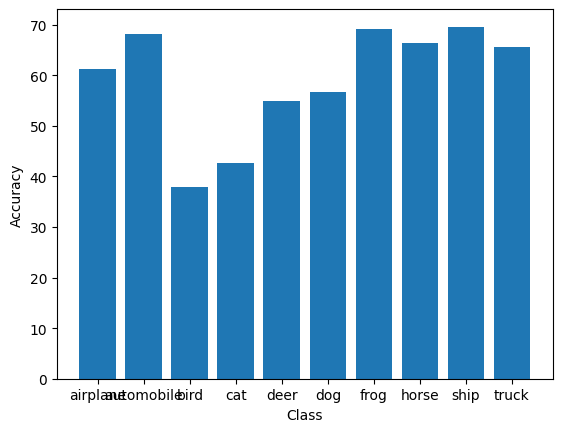

In [21]:
import matplotlib.pyplot as plt

# 標籤
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 繪製長條圖
plt.bar(class_names, acctol)

# 添加標題和標籤
plt.xlabel('Class')
plt.ylabel('Accuracy')

# 顯示圖形
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
# predict = predict.flatten()
# label = label.flatten()
pre_y = predict[0]
test_y = label[0]
for arr in predict[1:]:
    # print(arr)
    pre_y = np.concatenate((pre_y, arr), axis=0)
for arr in label[1:]:
    # print(arr)
    test_y = np.concatenate((test_y, arr), axis=0)
print(pre_y)
cm=confusion_matrix(test_y,pre_y)


[8 0 0 ... 9 9 7]


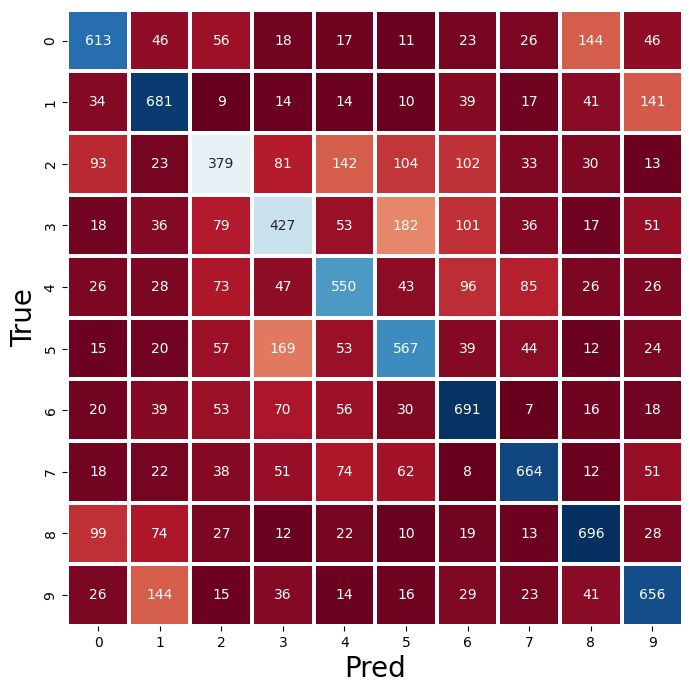

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()